Total Sales by Product:
              name         category  total_sales
0           LED TV      Electronics      70000.0
1       Smartphone      Electronics      45000.0
2  Washing Machine  Home Appliances      22000.0
3   Microwave Oven  Home Appliances       9000.0
4            Jeans         Clothing       6000.0
5          T-Shirt         Clothing       4500.0

Monthly Sales Trend:
     month  monthly_sales
0  2023-01        65000.0
1  2023-02        25600.0
2  2023-03        11500.0
3  2023-04        17400.0
4  2023-05        37000.0

Customer Segmentation:
   customer_id          name     region  purchase_frequency  total_spend
0            2  Priya Sharma     Mumbai                   2      50000.0
1            4    Neha Gupta      Delhi                   2      37500.0
2            1  Rajesh Kumar      Delhi                   2      33600.0
3            3    Amit Singh  Bengaluru                   2      24400.0
4            5  Suresh Patel  Ahmedabad                   2      1

/tmp/ipython-input-3813695334.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_sales', y='name', data=df_total_sales, palette='viridis')


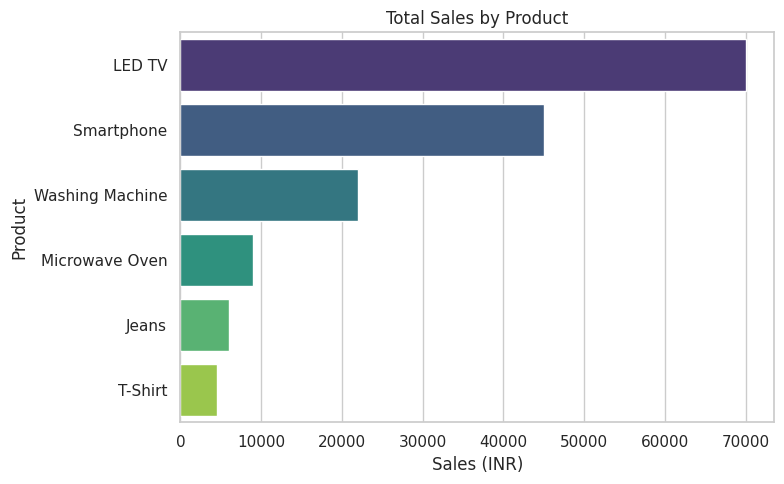

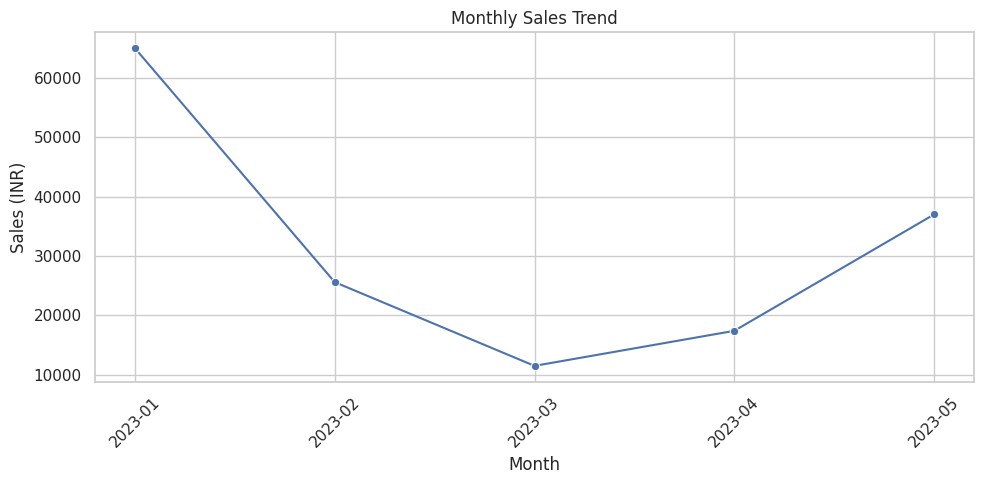

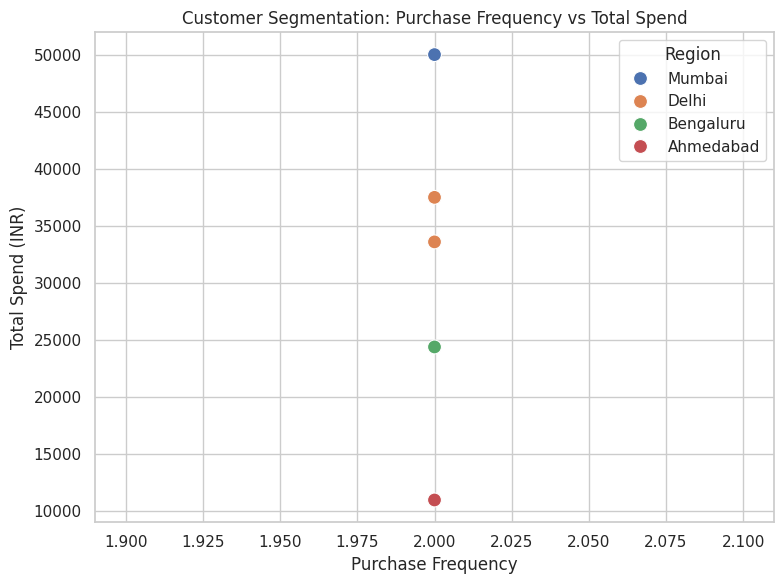

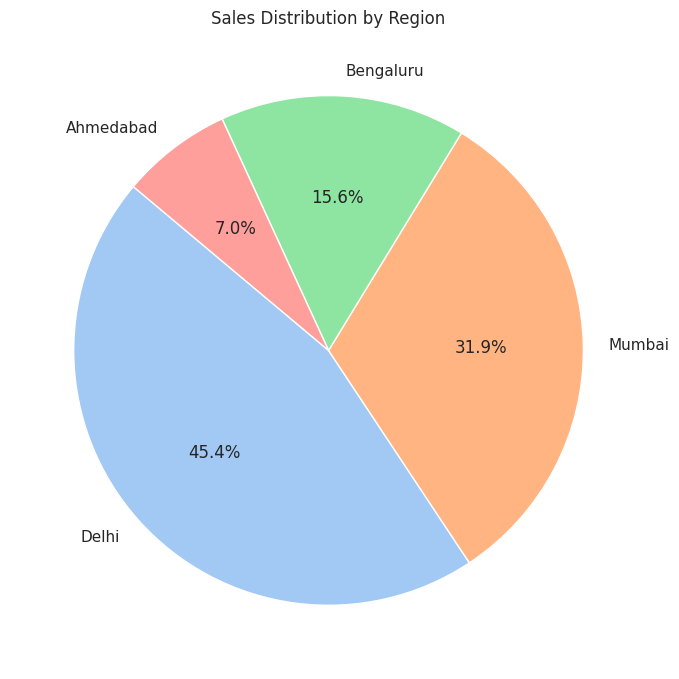

/tmp/ipython-input-3813695334.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category_sales', y='category', data=df_category_performance, palette='coolwarm')


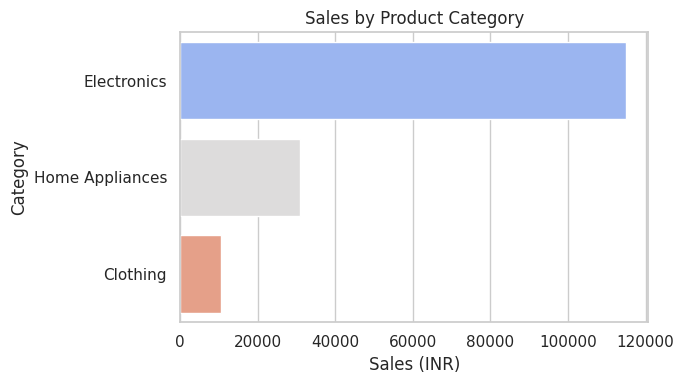

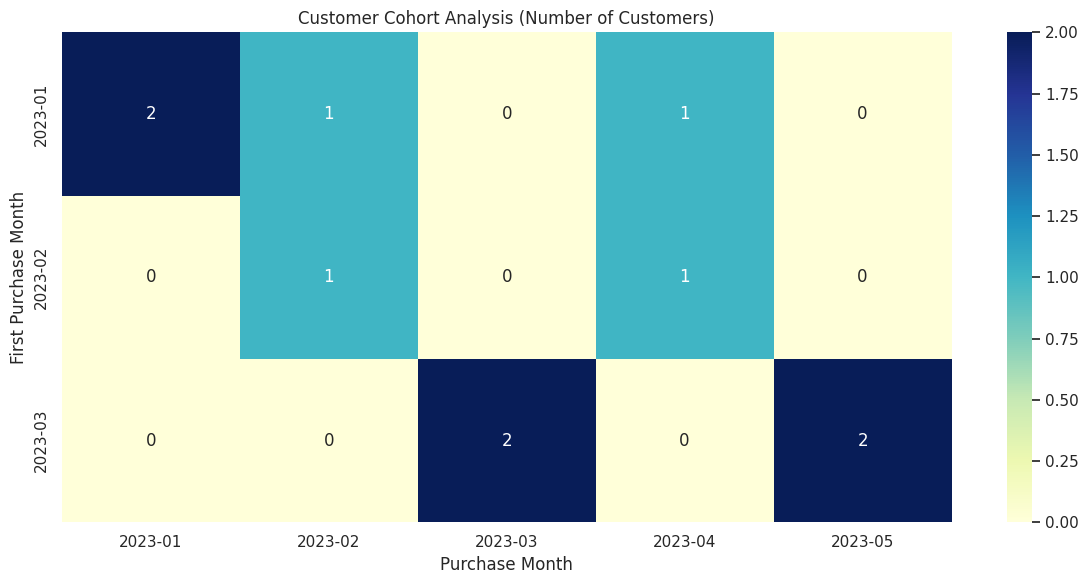

In [4]:
#E-Commerce Sales & Customer Cohort Analytics Using Python and SQL
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup DB connection
conn = sqlite3.connect('ecommerce_advanced.db')
cursor = conn.cursor()

# Create tables (if not exists)
cursor.executescript('''
CREATE TABLE IF NOT EXISTS Products (
    product_id INTEGER PRIMARY KEY,
    name TEXT,
    category TEXT,
    price REAL
);

CREATE TABLE IF NOT EXISTS Customers (
    customer_id INTEGER PRIMARY KEY,
    name TEXT,
    email TEXT,
    region TEXT
);

CREATE TABLE IF NOT EXISTS Orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date TEXT,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
);

CREATE TABLE IF NOT EXISTS OrderItems (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    FOREIGN KEY (order_id) REFERENCES Orders(order_id),
    FOREIGN KEY (product_id) REFERENCES Products(product_id)
);
''')
conn.commit()

# Insert sample data (use OR IGNORE to avoid duplicates on reruns)
products = [
    (1, 'Smartphone', 'Electronics', 15000),
    (2, 'LED TV', 'Electronics', 35000),
    (3, 'Washing Machine', 'Home Appliances', 22000),
    (4, 'Microwave Oven', 'Home Appliances', 9000),
    (5, 'Jeans', 'Clothing', 1200),
    (6, 'T-Shirt', 'Clothing', 500)
]

customers = [
    (1, 'Rajesh Kumar', 'rajesh.kumar@example.in', 'Delhi'),
    (2, 'Priya Sharma', 'priya.sharma@example.in', 'Mumbai'),
    (3, 'Amit Singh', 'amit.singh@example.in', 'Bengaluru'),
    (4, 'Neha Gupta', 'neha.gupta@example.in', 'Delhi'),
    (5, 'Suresh Patel', 'suresh.patel@example.in', 'Ahmedabad')
]

orders = [
    (1, 1, '2023-01-05'),
    (2, 2, '2023-01-15'),
    (3, 1, '2023-02-10'),
    (4, 3, '2023-02-18'),
    (5, 4, '2023-03-20'),
    (6, 5, '2023-03-25'),
    (7, 2, '2023-04-05'),
    (8, 3, '2023-04-18'),
    (9, 4, '2023-05-01'),
    (10, 5, '2023-05-10')
]

order_items = [
    (1, 1, 1, 2),   # Rajesh bought 2 Smartphones on Jan 5
    (2, 2, 2, 1),   # Priya bought 1 LED TV on Jan 15
    (3, 3, 5, 3),   # Rajesh bought 3 Jeans on Feb 10
    (4, 4, 3, 1),   # Amit bought 1 Washing Machine on Feb 18
    (5, 5, 6, 5),   # Neha bought 5 T-Shirts on Mar 20
    (6, 6, 4, 1),   # Suresh bought 1 Microwave Oven on Mar 25
    (7, 7, 1, 1),   # Priya bought 1 Smartphone on Apr 5
    (8, 8, 5, 2),   # Amit bought 2 Jeans on Apr 18
    (9, 9, 2, 1),   # Neha bought 1 LED TV on May 1
    (10, 10, 6, 4)  # Suresh bought 4 T-Shirts on May 10
]

# Insert data
cursor.executemany("INSERT OR IGNORE INTO Products VALUES (?, ?, ?, ?)", products)
cursor.executemany("INSERT OR IGNORE INTO Customers VALUES (?, ?, ?, ?)", customers)
cursor.executemany("INSERT OR IGNORE INTO Orders VALUES (?, ?, ?)", orders)
cursor.executemany("INSERT OR IGNORE INTO OrderItems VALUES (?, ?, ?, ?)", order_items)
conn.commit()

# 1) Total Sales per Product (with category)
query_total_sales = '''
SELECT p.name, p.category, SUM(oi.quantity * p.price) AS total_sales
FROM OrderItems oi
JOIN Products p ON oi.product_id = p.product_id
GROUP BY p.product_id
ORDER BY total_sales DESC;
'''

df_total_sales = pd.read_sql_query(query_total_sales, conn)
print("Total Sales by Product:")
print(df_total_sales)

# 2) Monthly Sales Trend (Total Sales per Month)
query_monthly_sales = '''
SELECT
    strftime('%Y-%m', o.order_date) AS month,
    SUM(oi.quantity * p.price) AS monthly_sales
FROM Orders o
JOIN OrderItems oi ON o.order_id = oi.order_id
JOIN Products p ON oi.product_id = p.product_id
GROUP BY month
ORDER BY month;
'''

df_monthly_sales = pd.read_sql_query(query_monthly_sales, conn)
print("\nMonthly Sales Trend:")
print(df_monthly_sales)

# 3) Customer Segmentation by Total Spend and Purchase Frequency
query_customer_segmentation = '''
SELECT
    c.customer_id,
    c.name,
    c.region,
    COUNT(DISTINCT o.order_id) AS purchase_frequency,
    SUM(oi.quantity * p.price) AS total_spend
FROM Customers c
LEFT JOIN Orders o ON c.customer_id = o.customer_id
LEFT JOIN OrderItems oi ON o.order_id = oi.order_id
LEFT JOIN Products p ON oi.product_id = p.product_id
GROUP BY c.customer_id
ORDER BY total_spend DESC;
'''

df_customer_segmentation = pd.read_sql_query(query_customer_segmentation, conn)
print("\nCustomer Segmentation:")
print(df_customer_segmentation)

# 4) Region-wise Sales
query_region_sales = '''
SELECT
    c.region,
    SUM(oi.quantity * p.price) AS total_sales
FROM Customers c
JOIN Orders o ON c.customer_id = o.customer_id
JOIN OrderItems oi ON o.order_id = oi.order_id
JOIN Products p ON oi.product_id = p.product_id
GROUP BY c.region
ORDER BY total_sales DESC;
'''

df_region_sales = pd.read_sql_query(query_region_sales, conn)
print("\nRegion-wise Sales:")
print(df_region_sales)

# 5) Product Category Performance (Total Sales)
query_category_performance = '''
SELECT
    p.category,
    SUM(oi.quantity * p.price) AS category_sales
FROM OrderItems oi
JOIN Products p ON oi.product_id = p.product_id
GROUP BY p.category
ORDER BY category_sales DESC;
'''

df_category_performance = pd.read_sql_query(query_category_performance, conn)
print("\nProduct Category Performance:")
print(df_category_performance)

# 6) Cohort Analysis (Customer First Purchase Month vs Repeat Purchases)
query_cohort = '''
WITH FirstPurchase AS (
    SELECT
        customer_id,
        MIN(strftime('%Y-%m', order_date)) AS first_month
    FROM Orders
    GROUP BY customer_id
), Purchases AS (
    SELECT
        customer_id,
        strftime('%Y-%m', order_date) AS purchase_month
    FROM Orders
)
SELECT
    f.first_month,
    p.purchase_month,
    COUNT(DISTINCT p.customer_id) AS customers
FROM FirstPurchase f
JOIN Purchases p ON f.customer_id = p.customer_id
GROUP BY f.first_month, p.purchase_month
ORDER BY f.first_month, p.purchase_month;
'''

df_cohort = pd.read_sql_query(query_cohort, conn)
print("\nCohort Analysis Data:")
print(df_cohort)

# -----------------------------
# Visualization Section (using seaborn/matplotlib)
sns.set(style="whitegrid")

# Total Sales by Product
plt.figure(figsize=(8,5))
sns.barplot(x='total_sales', y='name', data=df_total_sales, palette='viridis')
plt.title('Total Sales by Product')
plt.xlabel('Sales (INR)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Monthly Sales Trend
plt.figure(figsize=(10,5))
sns.lineplot(data=df_monthly_sales, x='month', y='monthly_sales', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Customer Segmentation - Scatter plot of Frequency vs Spend
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_customer_segmentation, x='purchase_frequency', y='total_spend', hue='region', s=100)
plt.title('Customer Segmentation: Purchase Frequency vs Total Spend')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend (INR)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

# Region-wise Sales Pie Chart
plt.figure(figsize=(7,7))
plt.pie(df_region_sales['total_sales'], labels=df_region_sales['region'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Sales Distribution by Region')
plt.tight_layout()
plt.show()

# Category Performance Bar Chart
plt.figure(figsize=(7,4))
sns.barplot(x='category_sales', y='category', data=df_category_performance, palette='coolwarm')
plt.title('Sales by Product Category')
plt.xlabel('Sales (INR)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Cohort Heatmap for customer retention
df_pivot = df_cohort.pivot(index='first_month', columns='purchase_month', values='customers').fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(df_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Customer Cohort Analysis (Number of Customers)')
plt.xlabel('Purchase Month')
plt.ylabel('First Purchase Month')
plt.tight_layout()
plt.show()

# Close connection
conn.close()
